### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from typing import List, Any

import torch
import torch.distributions as D
from torch_geometric.loader import DataLoader
import torch_geometric.utils as pyg_utils
from torch_geometric.data import Batch
import networkx as nx
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from matplotlib.lines import Line2D

from data_utils import *
from graph_vae.vae import GraphVAE

### Load Model and Dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# uncomment one of the following lines depending on which model you want to use
checkpoint = "./checkpoints/graph_vae_20240607_021012.pt" # HOMO with latent split; kl_weight=0.01, kl_weight_property=0.1
# checkpoint = "./checkpoints/graph_vae_20240607_033607.pt" # LUMO with latent split; kl_weight=0.01, kl_weight_property=0.1
# checkpoint = "./checkpoints/graph_vae_20240607_050344.pt" # R2 with latent split; kl_weight=0.01, kl_weight_property=0.1

model = GraphVAE.from_pretrained(checkpoint_path=checkpoint).to(device)
model.eval()

# property names used in the plots of this notebook
property_to_name_map = {
    "lumo": "LUMO (eV)",
    "homo": "HOMO (eV)",
    "r2": r"R2 ($\AA^2$)"
}
property_name = property_to_name_map[model.properties[0]]

property_to_target_value_map = {
    "lumo": [-4.0, -2.0, 0, 2.0, 4.0],
    "homo": [-8.5, -7.5, -6.5, -5.5, -4.5],
    "r2": [500, 1000, 1500, 2000, 2500]
}
target_property_values = property_to_target_value_map[model.properties[0]]

print(f"Loaded model trained on properties: {model.properties}")

include_hydrogen = False
prop_norm_df = create_or_load_property_norm_df()
# create dataset and dataloaders
dataset = create_qm9_graph_vae_dataset(
    device=device, 
    include_hydrogen=include_hydrogen,
    refresh_data_cache=False,
    properties=model.properties,
    prop_norm_df=prop_norm_df
)

batch_size = 1024

full_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
dataset_properties = list()
dataset_smiles_properties = dict()
for batch in tqdm(full_loader, desc="Getting Dataset Property Distribution"):
    properties = model.denormalize_properties(batch.y)
    dataset_properties.append(properties)
    for sample_index in range(len(batch)):
        sample = batch[sample_index]
        mol = graph_to_mol(data=sample, includes_h=include_hydrogen, validate=False)
        dataset_smiles_properties[Chem.MolToSmiles(mol)] = model.denormalize_properties(sample.y)

Loaded model trained on properties: ['homo']


Getting Dataset Property Distribution: 100%|██████████| 126/126 [03:49<00:00,  1.82s/it]


### Find best matches in the dataset

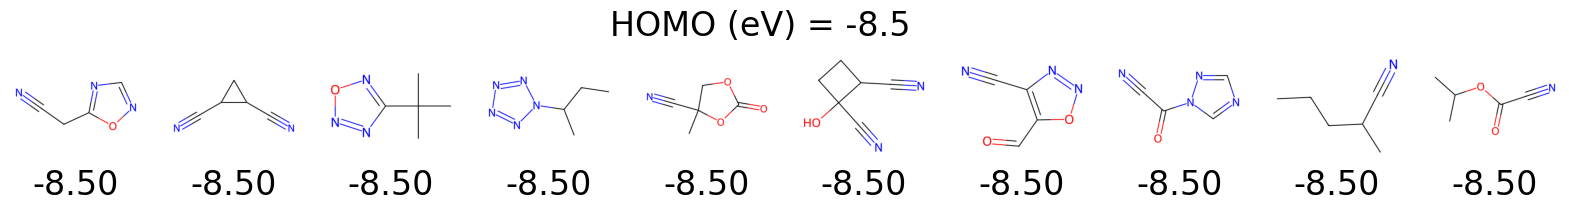

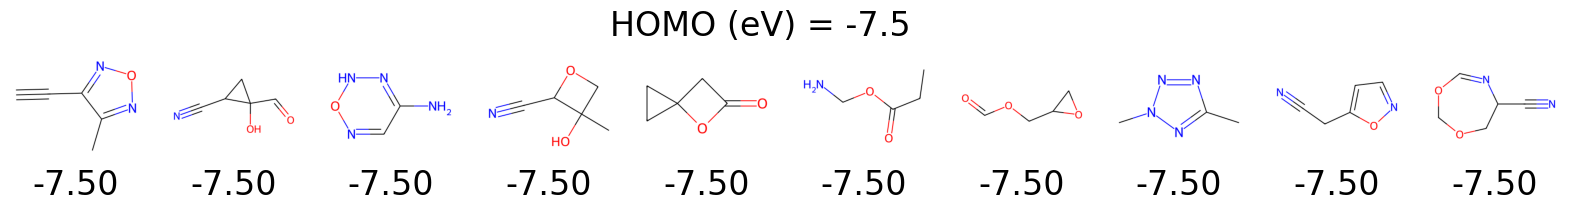

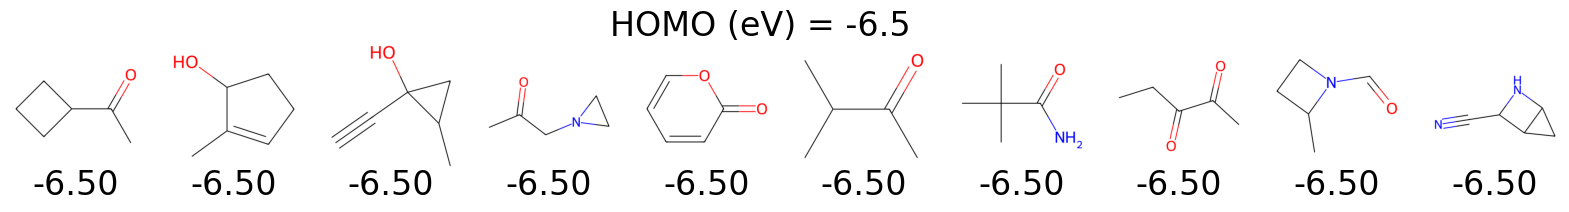

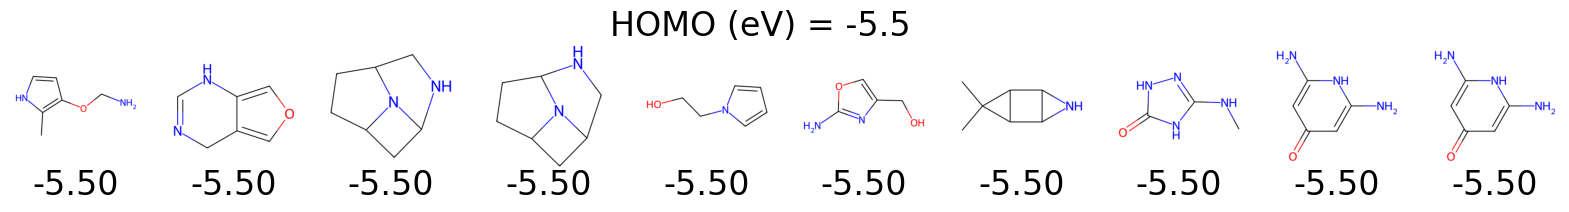

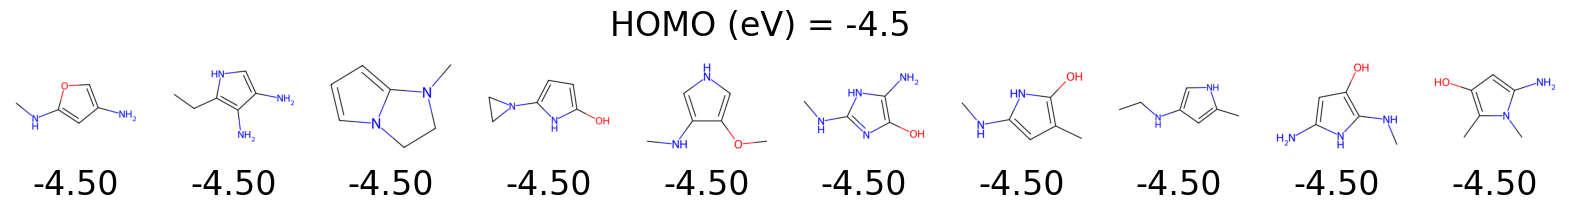

In [3]:
for target_value in target_property_values:
    y = torch.cat(dataset_properties, dim=0)[:, 0]
    y_delta = (y - target_value).abs()

    k = 10
    indices = torch.topk(y_delta, k=k, largest=False).indices
    best_dataset = dataset[indices]
    best_properties = y[indices]
    mols = [graph_to_mol(data=graph, includes_h=include_hydrogen, validate=True) for graph in best_dataset]

    best_dataset_loader = DataLoader(best_dataset, batch_size=64, shuffle=False)
    with torch.no_grad():
        z = model.encode_mean(next(iter(best_dataset_loader)))
        y_pred_mu, y_pred_sigma = model.predict_properties(z=z)
        y_pred_mu = model.denormalize_properties(y_pred_mu)
        y_pred_sigma = model.denormalize_properties_std(y_pred_sigma)

    # get the molecules that most likely have the target property value
    normal_distribution = D.Normal(loc=y_pred_mu, scale=y_pred_sigma)
    log_likelihoods = normal_distribution.log_prob(torch.full(y_pred_mu.shape, target_value, device=y_pred_mu.device)).flatten()
   
    fig, axs = plt.subplots(1, k, figsize=(k * 2, 2))
    fig.suptitle(f"{property_name} = {target_value}", fontsize=24)
    axs = axs.flatten()
    for i in range(k):
        ax = axs[i]
        ax.imshow(Draw.MolToImage(mols[i]))
        ax.text(0.5, -0.1, f"{best_properties[i]:.2f}", fontsize=24, ha='center', va='center', transform=ax.transAxes)
        ax.axis("off")

### Sample Posterior

In [4]:
def sample_posterior(model: GraphVAE, target_property_value: float):
    y_target = torch.tensor(data=[target_property_value], device=device).unsqueeze(0)
    y_target_norm = model.normalize_properties(y=y_target)

    def pyro_model(y_obs):
        z = pyro.sample("z", dist.Normal(torch.zeros(model.property_z_size, device=device), torch.ones(model.property_z_size, device=device))).unsqueeze(0)
        y_mu, y_sigma = model.predict_properties(z)
        with pyro.plate("data"):
            pyro.sample("obs", dist.Normal(y_mu, y_sigma), obs=y_obs)

    # Define the MCMC kernel, here using NUTS, which is good for continuous parameters
    nuts_kernel = NUTS(pyro_model)

    sample_count = 3000

    while True:
        try:
            # Run the MCMC sampler
            mcmc = MCMC(nuts_kernel, num_samples=sample_count, warmup_steps=1000, disable_validation=False)
            mcmc.run(y_obs=y_target_norm)
        except Exception as e:
            print(e)
            continue
        break
    posterior_samples = mcmc.get_samples()["z"]

    return posterior_samples


# this takes ~15 minutes
posterior_samples = []
for value in target_property_values:
    posterior_samples.append(sample_posterior(model=model, target_property_value=value))

Warmup:   0%|          | 1/4000 [00:00,  8.88it/s, step size=3.60e+00, acc. prob=1.000]

Sample: 100%|██████████| 4000/4000 [03:16, 20.38it/s, step size=5.71e-01, acc. prob=0.876]


### Posterior Latent Kernel Density Estimate

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 23.42it/s]


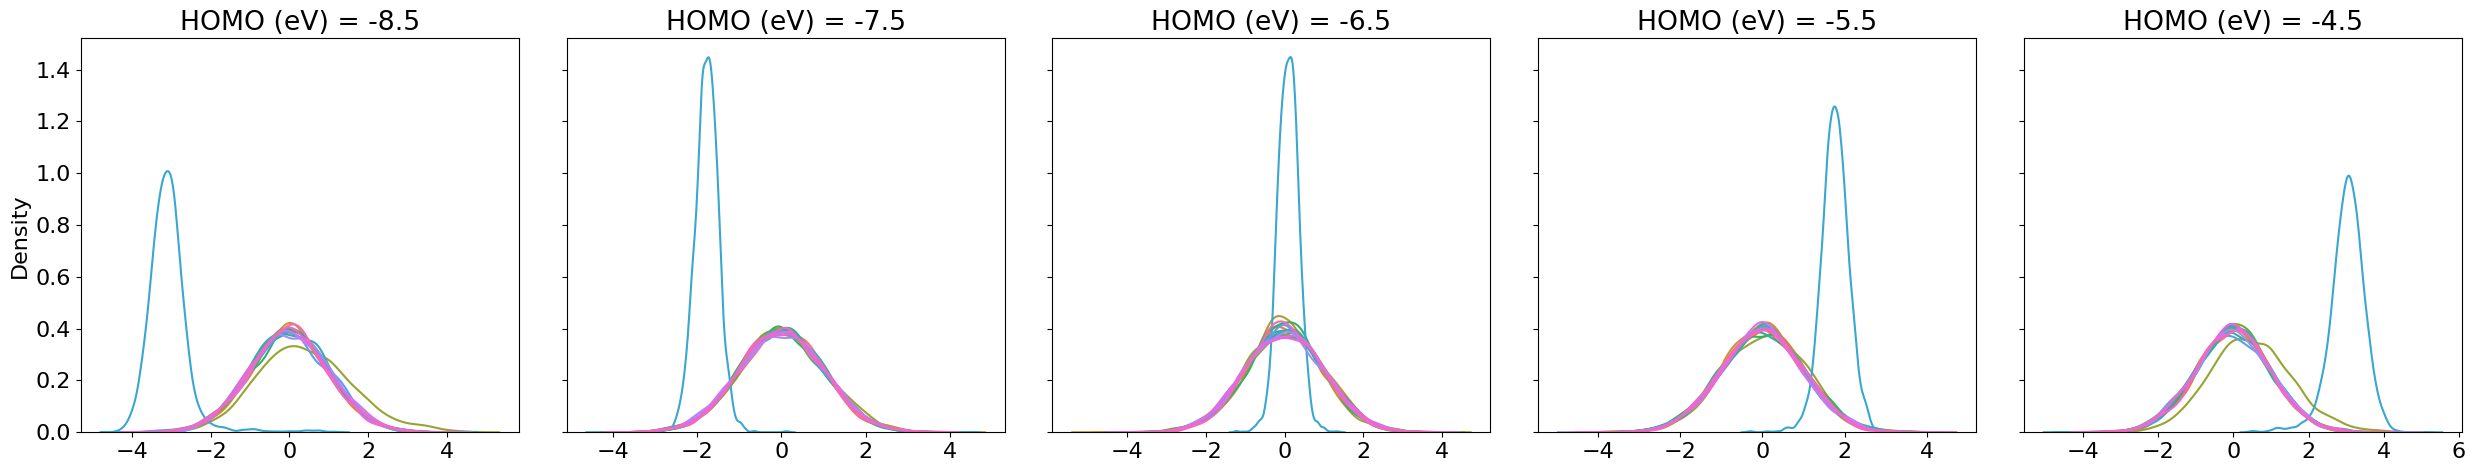

In [5]:
def plot_latent_kde(z: torch.Tensor, ax, title: str):
    """ Plot a kernel density estimate of each dimension of samples from the latent space. """
    z = z.detach().cpu()
    latent_dim = z.shape[1]
    palette = sns.color_palette("husl", latent_dim)
    for dim in tqdm(range(z.shape[1])):
        sns.kdeplot(z[:, dim], legend=False, color=palette[dim], ax=ax)
    
    ax.set_title(title)
    ax.set_ylabel('Density')

num_plots = len(posterior_samples)
fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)

for i in range(num_plots):
    z = posterior_samples[i]
    target = target_property_values[i]
    plot_latent_kde(z=z, ax=axes[i], title=f"{property_name} = {target}")

plt.tight_layout()
plt.show()

### PCA

  2%|▏         | 2/126 [00:00<00:37,  3.32it/s]

100%|██████████| 126/126 [00:40<00:00,  3.15it/s]


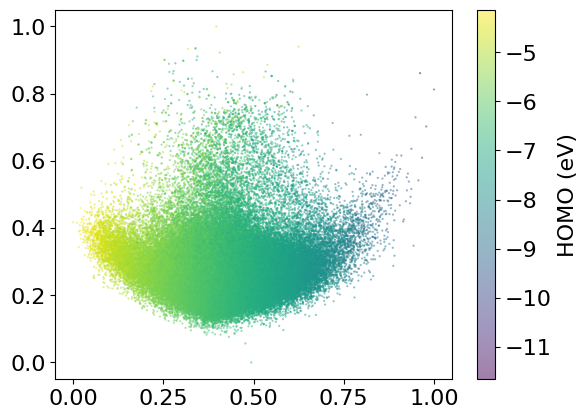

In [6]:
# encode dataset into latent space and plot PCA with points colored based on the molecule properties

def plot_dataset_latent_pca(model: GraphVAE, loader: DataLoader):
    z_list = []
    y_list = []
    for batch in tqdm(loader):
        with torch.no_grad():
            z_list.append(model.z_to_property_z(model.encode_mean(batch)))
            y_list.append(model.denormalize_properties(batch.y))

    z = torch.cat(z_list, dim=0).detach().cpu().numpy()
    y = torch.cat(y_list, dim=0).detach().cpu().numpy()

    z_pca = PCA(n_components=2).fit_transform(z)
    z_pca = MinMaxScaler().fit_transform(z_pca)

    scatter = plt.scatter(x= z_pca[:, 0], y=z_pca[:,1], c=y[:, 0],
                cmap= 'viridis', marker='.',
                s=10,alpha=0.5, edgecolors='none')
    plt.colorbar(scatter, label=property_name)
    plt.show()

plot_dataset_latent_pca(model=model, loader=full_loader)

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:40<00:00,  3.15it/s]


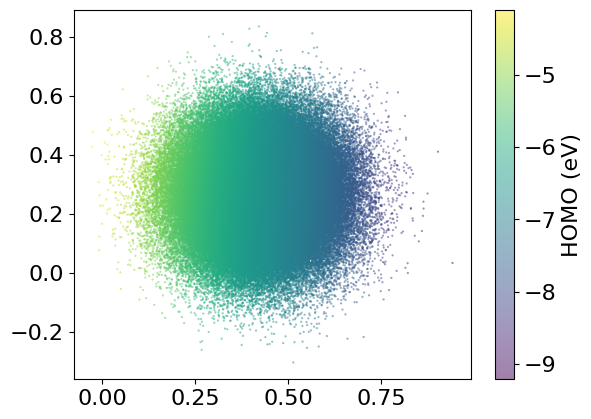

In [7]:
# plot PCA of random latent samples from prior with properties predicted by the model
# the principal components are computed based on the encoded dataset

def plot_sampled_latent_pca(model: GraphVAE, loader: DataLoader, device: str):
    z_dataset_list = []
    for batch in tqdm(loader):
        with torch.no_grad():
            z_dataset_list.append(model.z_to_property_z(model.encode_mean(batch)))

    z_dataset = torch.cat(z_dataset_list, dim=0).detach().cpu().numpy()
    pca_fitted = PCA(n_components=2).fit(z_dataset)
    z_pca_dataset = pca_fitted.transform(z_dataset)
    scaler_fitted = MinMaxScaler().fit(z_pca_dataset)

    z = torch.randn((200000, model.property_z_size), device=device)
    with torch.no_grad():
        y = model.denormalize_properties(model.predict_properties(z)[0])

    z = z.detach().cpu().numpy()
    y = y.detach().cpu().numpy()

    z_pca = pca_fitted.transform(z)
    z_pca = scaler_fitted.transform(z_pca)

    scatter = plt.scatter(x= z_pca[:, 0], y=z_pca[:,1], c=y[:, 0],
                cmap= 'viridis', marker='.',
                s=10,alpha=0.5, edgecolors='none')

    plt.colorbar(scatter, label=property_name)
    plt.show()                                              

plot_sampled_latent_pca(model=model, loader=full_loader, device=device)

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:39<00:00,  3.23it/s]


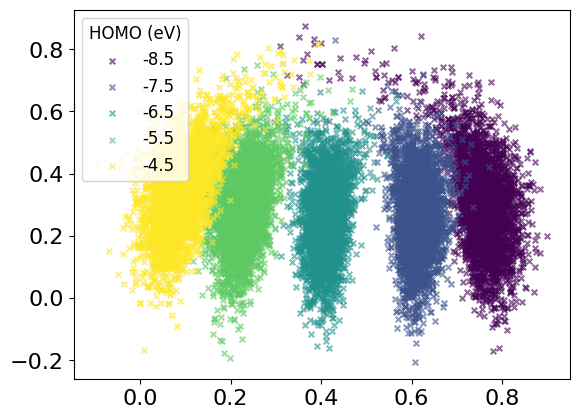

In [8]:
# PCA of posterior samples

def plot_posterior_latent_pca(model: GraphVAE, loader: DataLoader, posterior_samples: List[torch.Tensor], target_values: List[float]):
    z_dataset_list = []
    for batch in tqdm(loader):
        with torch.no_grad():
            z_dataset_list.append(model.z_to_property_z(model.encode_mean(batch)))

    z_dataset = torch.cat(z_dataset_list, dim=0).detach().cpu().numpy()
    pca_fitted = PCA(n_components=2).fit(z_dataset)
    z_pca_dataset = pca_fitted.transform(z_dataset)
    scaler_fitted = MinMaxScaler().fit(z_pca_dataset)

    z = torch.randn((200000, model.property_z_size), device=posterior_samples[0].device)
    with torch.no_grad():
        y = model.denormalize_properties(model.predict_properties(z)[0])
    z = z.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    z_pca = pca_fitted.transform(z)
    z_pca = scaler_fitted.transform(z_pca)

    cmap = plt.colormaps.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(posterior_samples)))

    for i in range(len(posterior_samples)):
        posterior_z = posterior_samples[i]
        target_value = target_values[i]
        z_pca = pca_fitted.transform(posterior_z.detach().cpu().numpy())
        z_pca = scaler_fitted.transform(z_pca)
        plt.scatter(x= z_pca[:, 0], y=z_pca[:,1], marker='x',
                    s=16, alpha=0.6, color=colors[i], label=f"{target_value}")
    
    plt.legend(fontsize=12, title=property_name, title_fontsize=12)
    plt.show()

plot_posterior_latent_pca(model=model, loader=full_loader, posterior_samples=posterior_samples, target_values=target_property_values)

### Posterior Property Distributions

In [9]:
def plot_property_kde(dataset_samples: np.array, target_samples: List[np.array], target_values: List[float], title: str, label: str):
    min_value = np.min(dataset_samples)
    for target_sample_array in target_samples:
        if np.min(target_sample_array) < min_value:
            min_value = np.min(target_sample_array)

    max_value = np.max(dataset_samples)
    for target_sample_array in target_samples:
        if np.max(target_sample_array) > max_value:
            max_value = np.max(target_sample_array)

    _, ax = plt.subplots(figsize=(10, 6))
    kde = gaussian_kde(dataset_samples)
    x_d = np.linspace(min_value, max_value, 2048)

    density = kde(x_d)
    ax.plot(x_d, density, color='red', linewidth=2, label="QM9")
    ax.set_xlabel(property_name)
    ax.set_ylabel("Density")

    cmap = plt.colormaps.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(target_samples)))

    for i in range(len(target_samples)):
        target_sample_array = target_samples[i]
        target_value = target_values[i]
        kde = gaussian_kde(target_sample_array)
        density = kde(x_d)
        color = colors[i]
        ax.plot(x_d, density, "--", color=color, linewidth=2)
        ax.scatter([target_value], [0], color=color, s=300, zorder=5)

    ax.set_ylim(0)

    # Custom legend
    custom_lines = [
        Line2D([0], [0], color='red', lw=2, label='QM9'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label=label),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=16, label='Targets')
    ]

    ax.legend(handles=custom_lines, loc='upper right')

    plt.title(title)
    plt.tight_layout()
    plt.show()

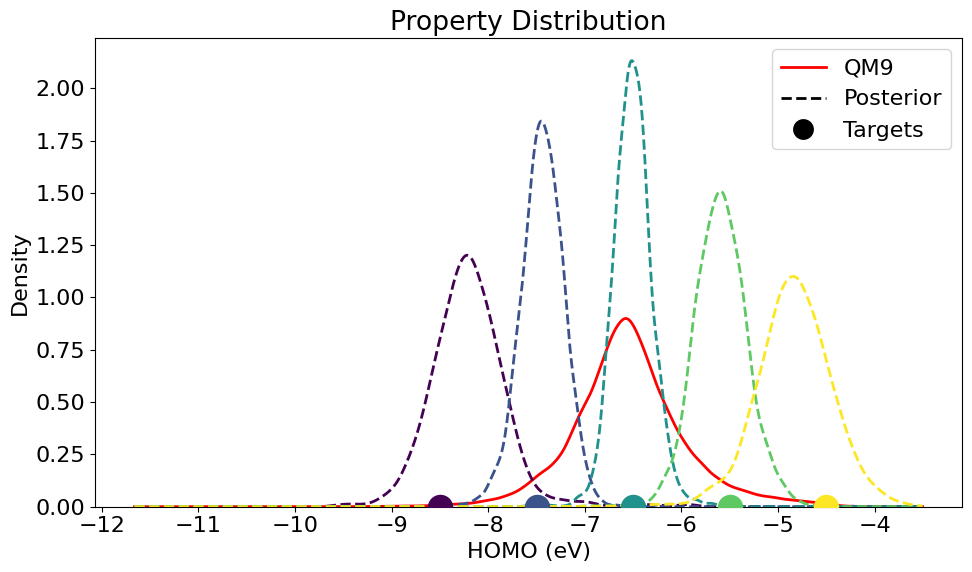

In [10]:
# Dataset property distribution
y_dataset = torch.cat(dataset_properties, dim=0)[:, 0].cpu().numpy()

y_list_with_uncertainty = []
for z in posterior_samples:
    with torch.no_grad():
        y_pred_mu, y_pred_sigma = model.predict_properties(z=z)
    y_sampled = model.denormalize_properties(y=torch.randn_like(y_pred_mu) * y_pred_sigma + y_pred_mu)
    y_list_with_uncertainty.append(y_sampled[:, 0].detach().cpu().numpy())

plot_property_kde(
    dataset_samples=y_dataset, target_samples=y_list_with_uncertainty, target_values=target_property_values, title="Property Distribution", label="Posterior"
)   

In [11]:
def decode_encode_posterior_samples(model: GraphVAE, z_posterior: torch.Tensor, target_value: float) -> Tuple[torch.Tensor, List[Any], torch.tensor]:
    """
    Decode samples from the latent distribution and re-encode them using the same model.
    """
    iteration_count = 1
    if model.latent_dim != model.property_z_size:
        # number of z2 samples
        iteration_count = 8

    valid_mol_graph_list = []
    valid_mol_list = []
    log_likelihood_list = []
    valid_smiles_set = set()  # used to filter duplicates

    with torch.no_grad():
        y_pred_mu, y_pred_sigma = model.predict_properties(z=z_posterior)
        y_pred_mu = model.denormalize_properties(y_pred_mu)
        y_pred_sigma = model.denormalize_properties_std(y_pred_sigma)

    # get the molecules that most likely have the target property value
    normal_distribution = D.Normal(loc=y_pred_mu, scale=y_pred_sigma)
    log_likelihoods = normal_distribution.log_prob(torch.full(y_pred_mu.shape, target_value, device=y_pred_mu.device)).flatten()

    for _ in range(iteration_count):
        if model.latent_dim != model.property_z_size:
            z_prop = z_posterior
            random_part = torch.randn(z_prop.shape[0], model.latent_dim - model.property_z_size, device=device)
            z = torch.cat((z_prop, random_part), dim=1)

        with torch.no_grad():
            x = model.decode(z)

        # number of decoder samples
        decode_count = 4
        for _ in range(decode_count):
            decoded_graphs = model.output_to_graph(x, stochastic=True)

            sample_count = len(decoded_graphs)
            for i in range(sample_count):
                graph = decoded_graphs[i]
                # Check if the generated graph is connected
                if not nx.is_connected(pyg_utils.to_networkx(graph, to_undirected=True)):
                    continue

                try:
                    mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=True)
                except Exception as e:
                    # Molecule is invalid
                    continue

                # Molecule is valid
                if mol:
                    # filter duplicates
                    smiles = Chem.MolToSmiles(mol)
                    if smiles not in valid_smiles_set:
                        valid_smiles_set.add(smiles)
                        valid_mol_graph_list.append(graph)
                        valid_mol_list.append(mol)
                        log_likelihood_list.append(log_likelihoods[i])

    # encode in chunks to avoid out-of-memory error
    chunk_size = 1024
    batch_list = [Batch.from_data_list(data_list=valid_mol_graph_list[i:i + chunk_size]) for i in range(0, len(valid_mol_graph_list), chunk_size)]
    reencoded_z_list = []
    for decoded_batch in tqdm(batch_list):
        with torch.no_grad():
            reencoded_z_list.append(model.encode_mean(decoded_batch))

    reencoded_z = torch.cat(reencoded_z_list, dim=0)
    return reencoded_z, valid_mol_list, torch.tensor(log_likelihood_list, device=reencoded_z.device)

reencoded_posterior_samples = []
target_property_log_likelihoods = []
decoded_mols_from_posterior_samples = []
for z, target_value in zip(posterior_samples, target_property_values):
    reencoded_z, decoded_mols, log_likelihoods = decode_encode_posterior_samples(model=model, z_posterior=z, target_value=target_value)
    reencoded_posterior_samples.append(reencoded_z)
    decoded_mols_from_posterior_samples.append(decoded_mols)
    target_property_log_likelihoods.append(log_likelihoods)

  2%|▏         | 59/3000 [00:00<00:05, 582.76it/s]

100%|██████████| 43/43 [00:00<00:00, 213.48it/s]


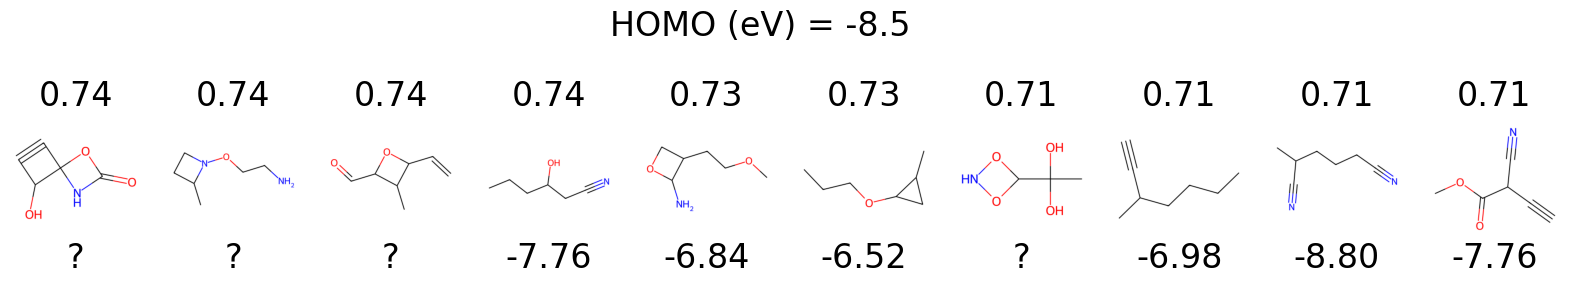

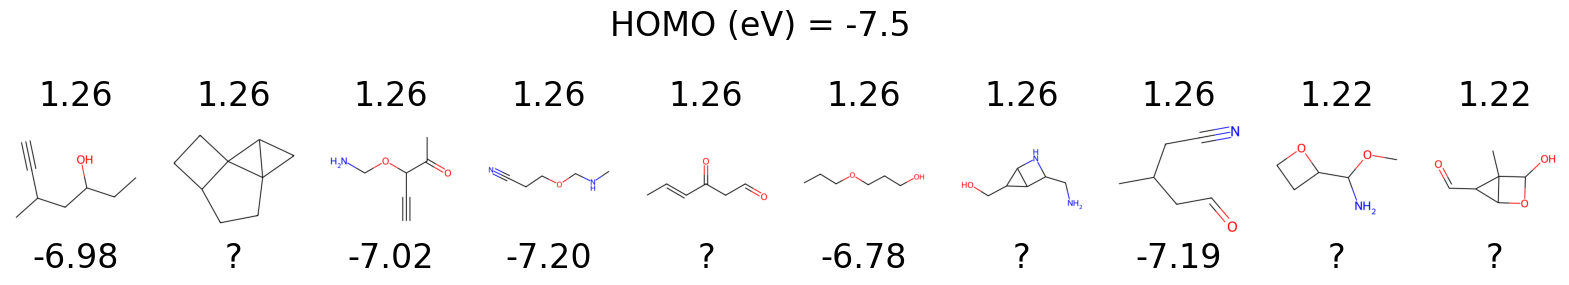

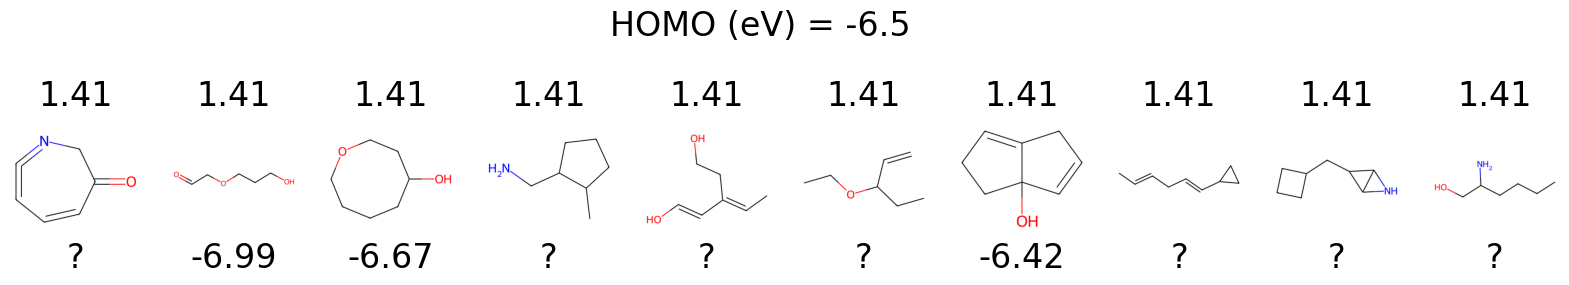

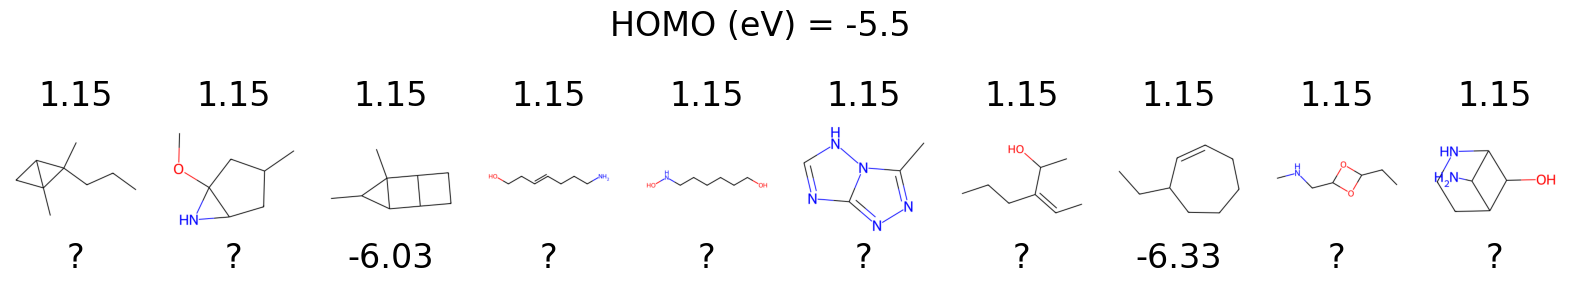

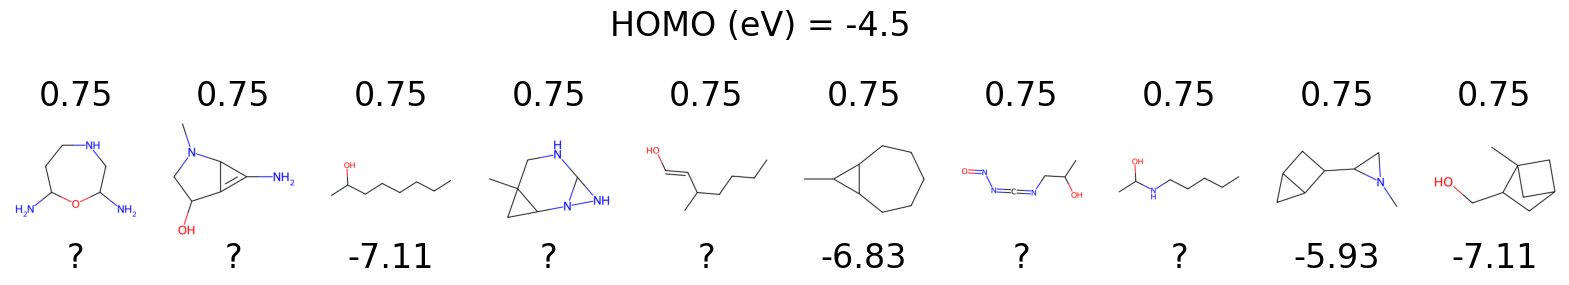

In [12]:
# top candidate molecules without considering the decoder
for mols, log_likelihoods, target_value in zip(decoded_mols_from_posterior_samples, target_property_log_likelihoods, target_property_values):
    k = 10
    top_log_likelihoods, indices = torch.topk(log_likelihoods, k=k, dim=0)
    index_list = indices.tolist()
    candidates = [mols[i] for i in index_list]
    
    fig, axs = plt.subplots(1, k, figsize=(k * 2, 3.5))
    fig.suptitle(f"{property_name} = {target_value}", fontsize=24)
    axs = axs.flatten()
    for i in range(k):
        ax = axs[i]
        ax.imshow(Draw.MolToImage(mols[i]))

        smiles = Chem.MolToSmiles(mols[i])
        if smiles in dataset_smiles_properties:
            true_property = dataset_smiles_properties[smiles].item()
            true_property_str = f"{true_property:.2f}"
        else:
            true_property_str = "?"

        ax.set_title(label=f"{top_log_likelihoods[i]:.2f}", fontsize=24)  # Title above the image
        ax.text(0.5, -0.1, true_property_str, fontsize=24, ha='center', va='center', transform=ax.transAxes)
        ax.axis("off")

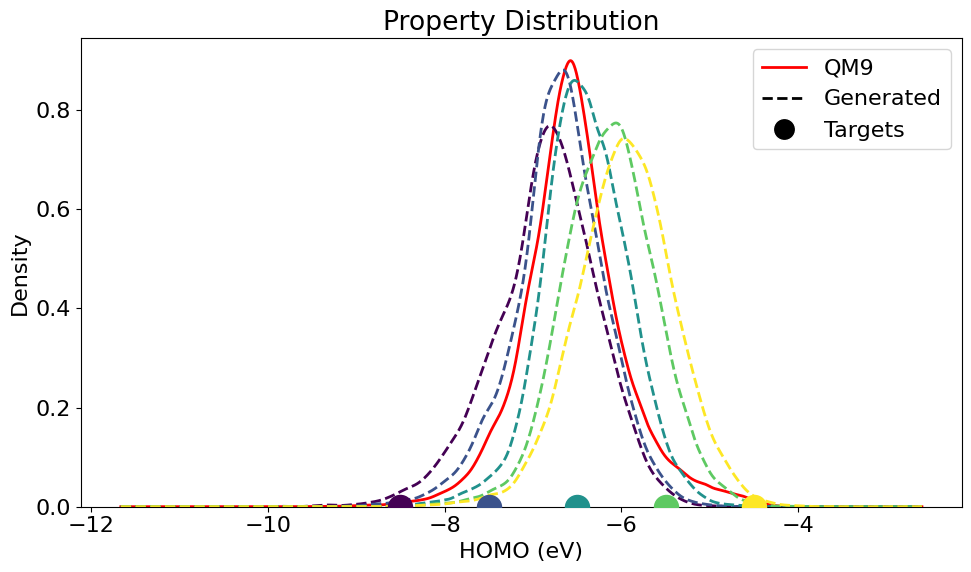

In [13]:
k = 10  # number of candidate molecules to select

y_list_with_uncertainty = []
best_candidate_mols = []  # molecules that are most likely to have the desired property
for z, target_value, mols in zip(reencoded_posterior_samples, target_property_values, decoded_mols_from_posterior_samples):
    with torch.no_grad():
        y_pred_mu, y_pred_sigma = model.predict_properties(z=z)
        y_pred_mu = model.denormalize_properties(y_pred_mu)
        y_pred_sigma = model.denormalize_properties_std(y_pred_sigma)

    # get the molecules that most likely have the target property value
    normal_distribution = D.Normal(loc=y_pred_mu, scale=y_pred_sigma)
    log_likelihood = normal_distribution.log_prob(torch.full(y_pred_mu.shape, target_value, device=y_pred_mu.device))
    top_log_likelihoods, indices = torch.topk(log_likelihood, k=k, dim=0)
    index_list = indices[:, 0].tolist()
    best_candidate_mols.append((top_log_likelihoods[:, 0].tolist(), [mols[i] for i in index_list]))

    y_sampled = torch.randn_like(y_pred_mu) * y_pred_sigma + y_pred_mu
    y_list_with_uncertainty.append(y_sampled[:, 0].detach().cpu().numpy())

plot_property_kde(
    dataset_samples=y_dataset, target_samples=y_list_with_uncertainty, target_values=target_property_values, title="Property Distribution", label="Generated"
)

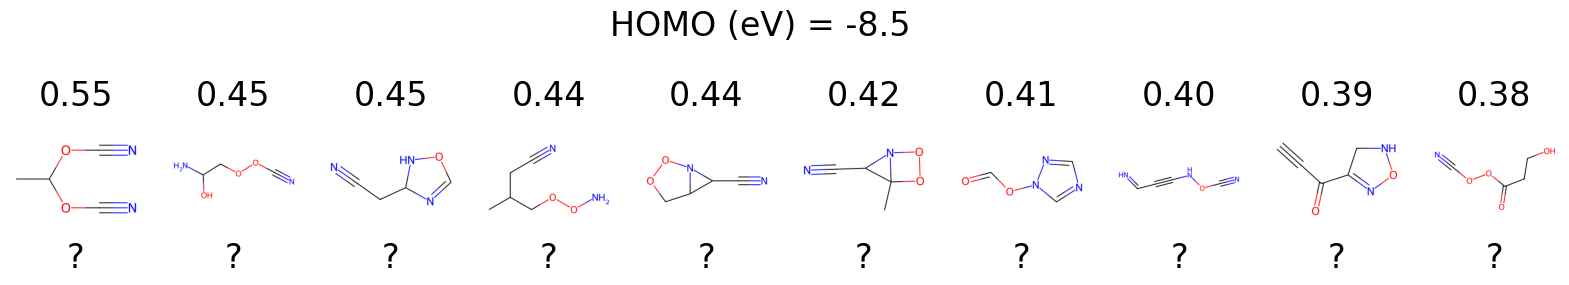

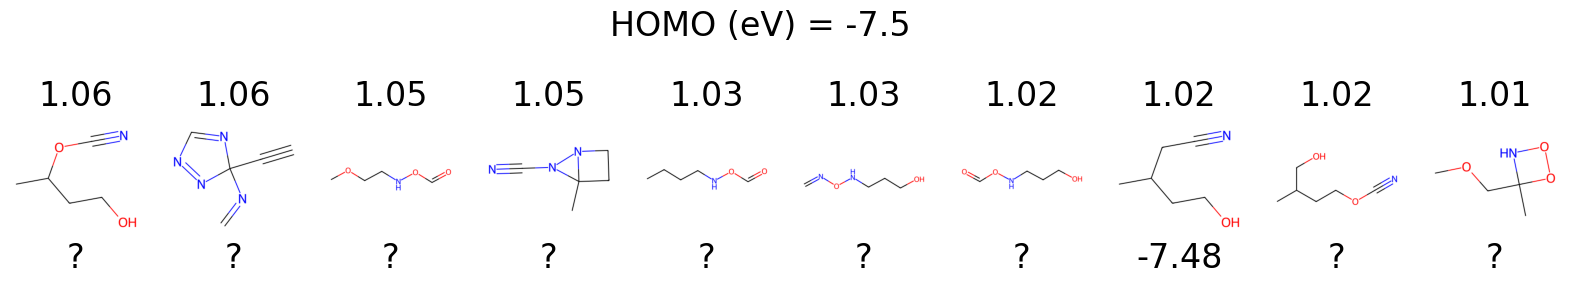

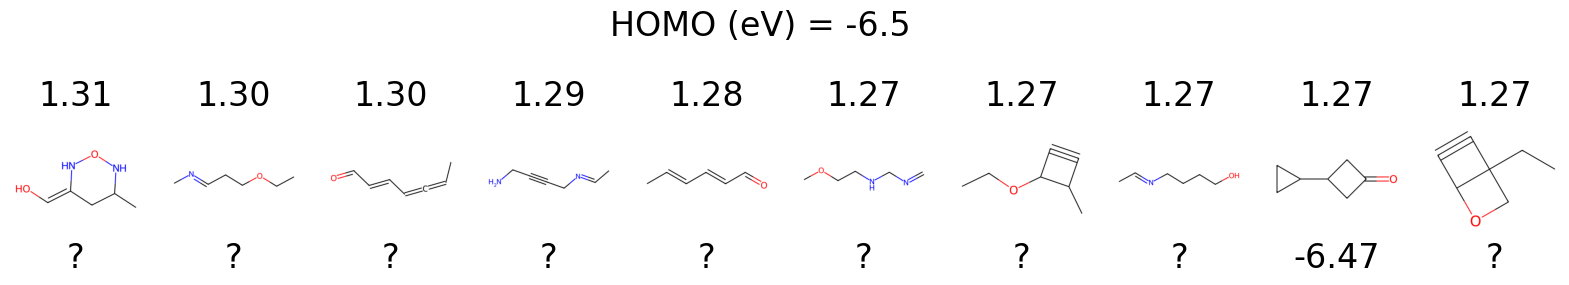

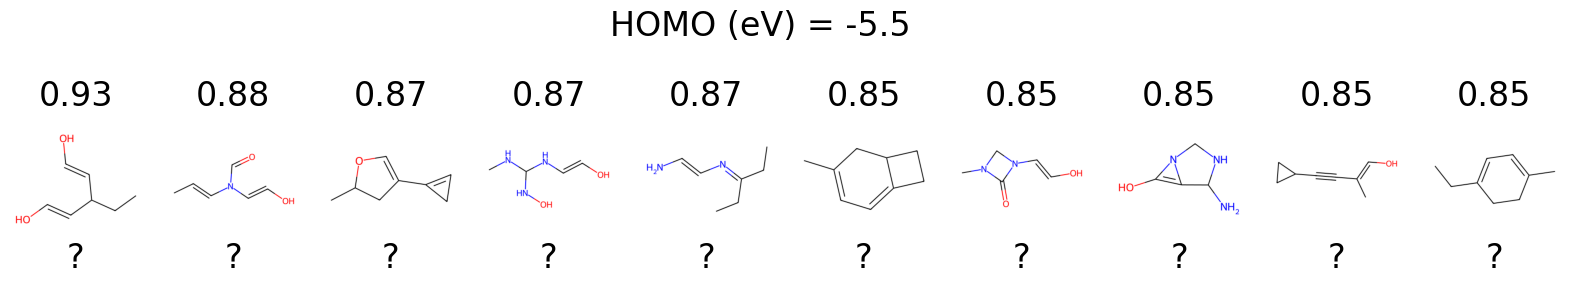

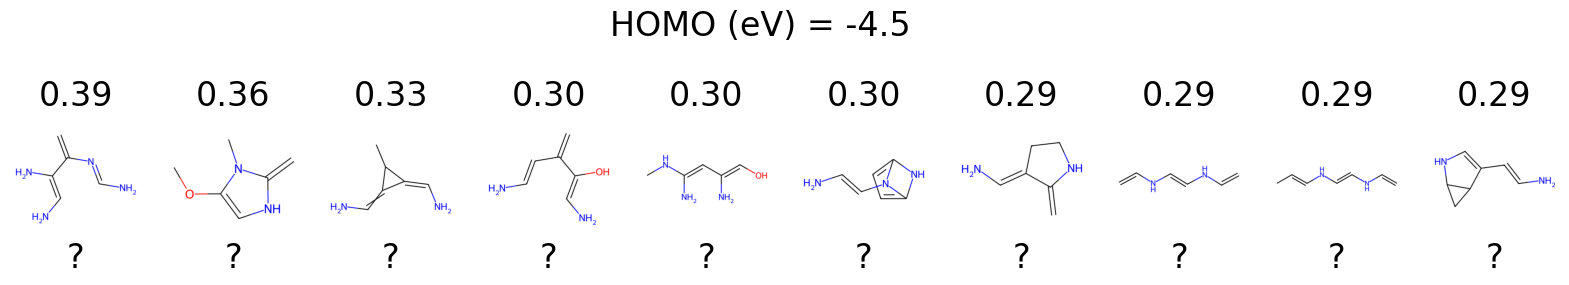

In [14]:
# plot molecules that are most likely to have the target property
for candidates, target_property_value in zip(best_candidate_mols, target_property_values):
    fig, axs = plt.subplots(1, k, figsize=(k * 2, 3.5))
    fig.suptitle(f"{property_name} = {target_property_value}", fontsize=24)
    axs = axs.flatten()
    log_likelihoods, mols = candidates
    for i in range(k):
        ax = axs[i]
        ax.imshow(Draw.MolToImage(mols[i]))
        
        smiles = Chem.MolToSmiles(mols[i])
        if smiles in dataset_smiles_properties:
            true_property = dataset_smiles_properties[smiles].item()
            true_property_str = f"{true_property:.2f}"
        else:
            true_property_str = "?"

        ax.set_title(label=f"{log_likelihoods[i]:.2f}", fontsize=24)  # Title above the image
        ax.text(0.5, -0.1, true_property_str, fontsize=24, ha='center', va='center', transform=ax.transAxes)
        ax.axis("off")